# Crypto Foundations: Keys, Wallets, Hashes, Mnemonics, and Signatures
_A college‑level hands‑on primer with Python examples and visualizations_


## What you'll learn
- Core terminology and mental models in cryptography
- How public/private keys work (with Elliptic Curve Cryptography on secp256k1 and Ed25519)
- Mnemonics (BIP‑39), seeds, and how wallets derive keys
- Hashing in practice: **SHA‑256 (Bitcoin)**, **Keccak‑256 (Ethereum)**, **BLAKE2**, and **xxHash**
- Symmetric vs asymmetric encryption (AES‑GCM, RSA‑OAEP)
- Digital signatures (ECDSA secp256k1, Ed25519, and RSA‑PSS)
- Visualizing avalanche effect and benchmarking hash functions
- Address formats (Bitcoin Base58Check, Ethereum hex address, Polkadot SS58 basics)


## Setup

In [1]:

# If running on a clean environment, uncomment the next lines to install dependencies.
# Note: Internet access may be required the first time you run these.
# %pip install matplotlib numpy pycryptodome ecdsa mnemonic xxhash bip-utils

import sys, platform, os, time, binascii, math, json, random, secrets, textwrap
print("Python:", sys.version)
print("Platform:", platform.platform())


Python: 3.11.3 (tags/v3.11.3:f3909b8, Apr  4 2023, 23:49:59) [MSC v.1934 64 bit (AMD64)]
Platform: Windows-10-10.0.26100-SP0



## Intro to Cryptography — Useful Terms & Mental Models

- **Confidentiality**: Only intended parties can read a message (encryption).
- **Integrity**: Data cannot be tampered with without detection (hashes, MACs, signatures).
- **Authentication**: Proving who you are (signatures, certificates).
- **Non‑repudiation**: A signer cannot credibly deny an action (digital signatures with audit).
- **Deterministic** vs **randomized** algorithms: hashing is deterministic; signatures often randomized (or derive deterministic nonces).
- **One‑way functions**: Easy to compute, hard to invert (hashes).
- **Entropy**: Measure of unpredictability; crucial for keys/nonces.
- **Key Derivation**: Deriving keys from seeds/passwords (PBKDF2, HKDF, scrypt, Argon2).
- **Public‑key crypto**: Key pair (private key + public key). Enables signatures and key exchange.
- **Symmetric crypto**: Same key for encryption & decryption (e.g., AES).


## Hash Functions in Practice: SHA‑256 (Bitcoin), Keccak‑256 (Ethereum), BLAKE2, xxHash


**Why hashing matters**: hashes are fingerprints of data, used in blockchains for blocks, transactions, Merkle trees, addresses, and signatures.

Below, we compute common hashes. Notes:
- Bitcoin uses **double‑SHA‑256** in several places (e.g., block headers).
- Ethereum uses **Keccak‑256** (slightly different from standardized SHA‑3).
- Polkadot & Substrate commonly use **BLAKE2**; **xxHash** is used for fast non‑cryptographic hashing in places (e.g., storage maps).

> ⚠️ *Keccak vs SHA‑3:* Ethereum's **Keccak‑256** differs in padding from **SHA3‑256**. We use PyCryptodome's `Crypto.Hash.keccak` for Ethereum‑style Keccak.


In [2]:

from Crypto.Hash import SHA256, RIPEMD160, keccak, BLAKE2b
import xxhash

def sha256(data: bytes) -> bytes:
    return SHA256.new(data).digest()

def double_sha256(data: bytes) -> bytes:
    return sha256(sha256(data))

def keccak_256(data: bytes) -> bytes:
    k = keccak.new(digest_bits=256)
    k.update(data)
    return k.digest()

def blake2b_256(data: bytes) -> bytes:
    # BLAKE2b can be parameterized to 256-bit output
    h = BLAKE2b.new(digest_bits=256)
    h.update(data)
    return h.digest()

def xxhash_64(data: bytes) -> bytes:
    # xxHash is non-cryptographic; here we use 64-bit variant for demo
    # Represent the 64-bit integer as 8 bytes big-endian
    x = xxhash.xxh64(data).intdigest()
    return x.to_bytes(8, "big")

msg = b"hello crypto world"
print("SHA-256:", sha256(msg).hex())
print("Double-SHA-256:", double_sha256(msg).hex())
print("Keccak-256:", keccak_256(msg).hex())
print("BLAKE2b-256:", blake2b_256(msg).hex())
print("xxHash64:", xxhash_64(msg).hex(), "(non-cryptographic)")


SHA-256: 7a3e2483e16d358efd44356e7672a0f7ab1a692443a4590194345fb006f0088e
Double-SHA-256: 7f352e1f1ffd8b00bc1b44e69de614949fba5cc9534549db95ef534ef501384e
Keccak-256: a38587c40d347cfefb79287e822170ca1e9afadd2c8f3233d3fd30b57aa1dc57
BLAKE2b-256: a09fac14004e2b5f30f0d61e8a96fb54016da7d5967d913e55a04c5e6776daa5
xxHash64: a132b6659eb3a155 (non-cryptographic)


### Visualizing Avalanche Effect

Small input changes should flip ~50% of hash bits on average. We'll measure bit differences between `X` and `X'` = `X` with one character changed.

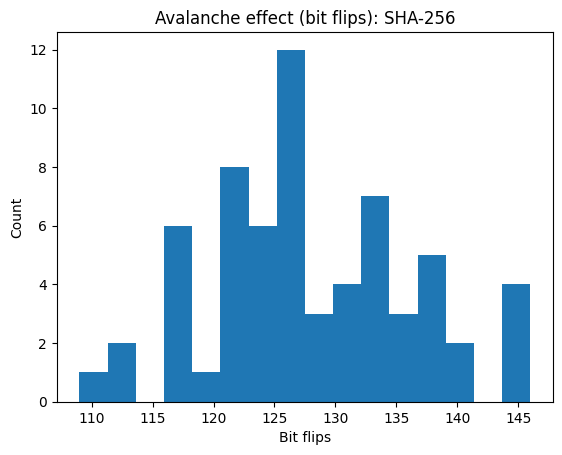

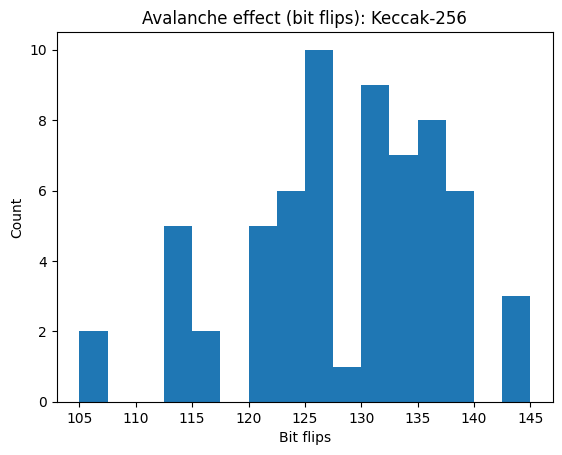

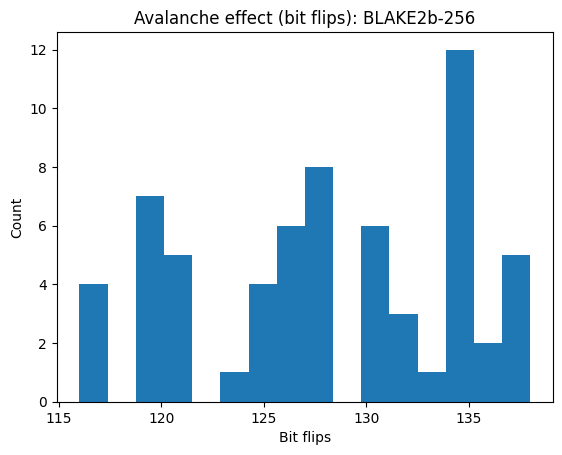

In [3]:

import numpy as np
import matplotlib.pyplot as plt

def bit_distance(a: bytes, b: bytes) -> int:
    # Hamming distance in bits
    return sum(bin(x ^ y).count("1") for x, y in zip(a, b))

def avalanche_demo(hash_fn, base: bytes, trials=40):
    dists = []
    for i in range(trials):
        # Flip one random byte
        idx = secrets.randbelow(len(base))
        mutated = bytearray(base)
        mutated[idx] ^= 1  # flip lowest bit of one byte
        d = bit_distance(hash_fn(base), hash_fn(mutated))
        dists.append(d)
    return np.array(dists)

base = b"Blockchains are built on cryptographic hash functions.\n"
hashers = [("SHA-256", sha256), ("Keccak-256", keccak_256), ("BLAKE2b-256", blake2b_256)]
for name, hf in hashers:
    d = avalanche_demo(hf, base, trials=64)
    plt.figure()
    plt.hist(d, bins=16)
    plt.title(f"Avalanche effect (bit flips): {name}")
    plt.xlabel("Bit flips")
    plt.ylabel("Count")
    plt.show()


### Benchmarking Hash Speeds

We benchmark hash times across different message sizes. (Times depend on your machine; this provides relative intuition.)

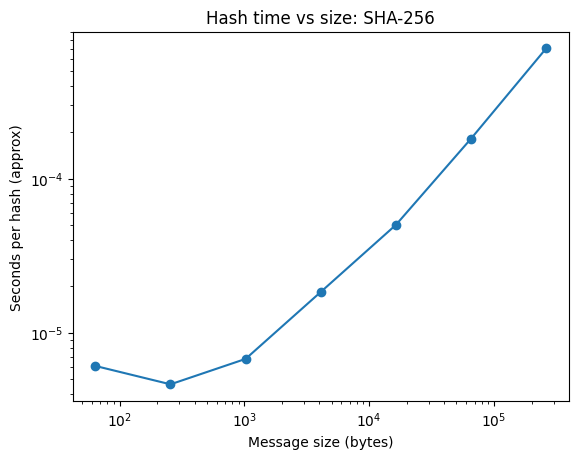

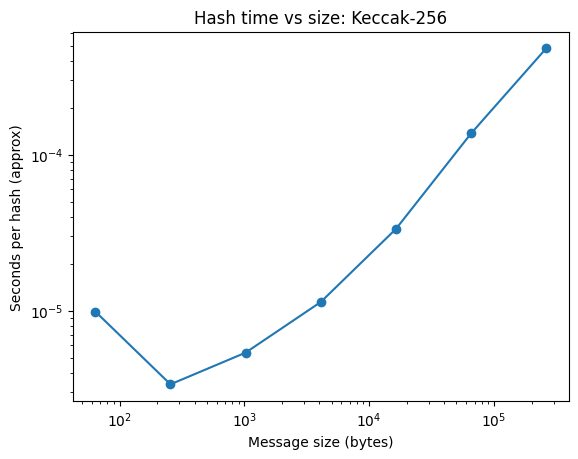

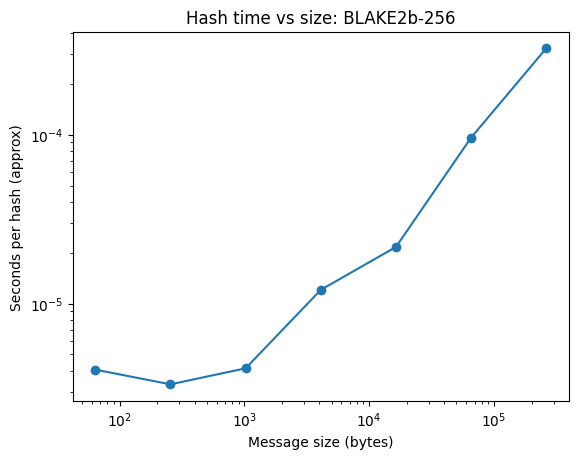

In [4]:

import time, statistics

rng = secrets.SystemRandom()
sizes = [2**k for k in range(6, 20, 2)]  # 64B .. 512KB
fns = [("SHA-256", sha256), ("Keccak-256", keccak_256), ("BLAKE2b-256", blake2b_256)]

import matplotlib.pyplot as plt

for name, fn in fns:
    times = []
    for sz in sizes:
        data = rng.randbytes(sz)
        t0 = time.perf_counter()
        for _ in range(25):
            fn(data)
        t1 = time.perf_counter()
        times.append((t1 - t0) / 25.0)
    plt.figure()
    plt.plot(sizes, times, marker="o")
    plt.title(f"Hash time vs size: {name}")
    plt.xlabel("Message size (bytes)")
    plt.ylabel("Seconds per hash (approx)")
    plt.xscale("log")
    plt.yscale("log")
    plt.show()


## Public & Private Keys — Elliptic Curve Cryptography (ECC)


We'll use two common curves:
- **secp256k1** (used by Bitcoin & Ethereum) for ECDSA signatures
- **Ed25519** (used widely including some Polkadot contexts) for fast, safe signatures

We'll derive an **Ethereum address** from a secp256k1 public key (Keccak‑256, last 20 bytes) and a **Bitcoin P2PKH** address (Base58Check over `ripemd160(sha256(pubkey))`, with version prefix).
We also demonstrate **SS58** address formatting (as used by Polkadot/Substrate) conceptually.


In [5]:
from ecdsa import SigningKey, SECP256k1
from Crypto.PublicKey import ECC
from Crypto.Hash import SHA256, RIPEMD160, keccak, BLAKE2b
import base64

# --- Utilities ---
alphabet = b"123456789ABCDEFGHJKLMNPQRSTUVWXYZabcdefghijkmnopqrstuvwxyz"

def base58_encode(b: bytes) -> str:
    n = int.from_bytes(b, "big")
    res = bytearray()
    while n > 0:
        n, r = divmod(n, 58)
        res.append(alphabet[r])
    # leading zeros
    pad = 0
    for ch in b:
        if ch == 0:
            pad += 1
        else:
            break
    return (alphabet[0:1] * pad + res[::-1]).decode()

def sha256(data: bytes) -> bytes:
    return SHA256.new(data).digest()

def double_sha256(data: bytes) -> bytes:
    return sha256(sha256(data))

def base58check_encode(version: bytes, payload: bytes) -> str:
    vh = version + payload
    checksum = double_sha256(vh)[:4]
    return base58_encode(vh + checksum)

def eth_address_from_pubkey(uncompressed_pubkey: bytes) -> str:
    # Ethereum address = last 20 bytes of Keccak-256 of 64-byte X||Y (without 0x04 prefix)
    assert uncompressed_pubkey[0] == 0x04 and len(uncompressed_pubkey) == 65
    k = keccak.new(digest_bits=256)
    k.update(uncompressed_pubkey[1:])  # drop 0x04
    return "0x" + k.digest()[-20:].hex()

def btc_p2pkh_from_pubkey(uncompressed_pubkey: bytes, mainnet=True) -> str:
    h160 = RIPEMD160.new(SHA256.new(uncompressed_pubkey).digest()).digest()
    version = b"\x00" if mainnet else b"\x6f"
    return base58check_encode(version, h160)

# --- secp256k1 keypair & addresses (using 'ecdsa' lib for k1) ---
sk = SigningKey.generate(curve=SECP256k1)               # private key
vk = sk.get_verifying_key()
# Uncompressed pubkey: 0x04 || X || Y
uncompressed = b"\x04" + vk.to_string()
eth_addr = eth_address_from_pubkey(uncompressed)
btc_addr = btc_p2pkh_from_pubkey(uncompressed, mainnet=True)

print("secp256k1 private key (hex):", sk.to_string().hex())
print("Ethereum address:", eth_addr)
print("Bitcoin P2PKH address:", btc_addr)

# --- Ed25519 key for SS58 demo (via ECC) ---
# Per docs: ECC supports curve='Ed25519'; EdDSA is in Crypto.Signature.eddsa
# Export the public key in 'raw' format (32 bytes) for SS58.
ed_key = ECC.generate(curve="Ed25519")  # Ed25519 via ECC
ed_pub = ed_key.public_key().export_key(format="raw")  # 32 bytes

def ss58_address(pubkey: bytes, ss58_prefix=42):
    # SS58 format (simplified): base58( [prefix_varint] + pubkey + checksum[:2] )
    # Checksum = blake2b_512("SS58PRE" || [prefix_varint] + pubkey), take first 2 bytes
    def to_ss58_format(prefix: int) -> bytes:
        if prefix < 64:  # simple one-byte varint for small prefixes
            return bytes([prefix])
        raise ValueError("Demo supports ss58_prefix < 64 only")

    data = to_ss58_format(ss58_prefix) + pubkey
    chk = BLAKE2b.new(digest_bits=512, data=b"SS58PRE" + data).digest()[:2]
    raw = data + chk
    return base58_encode(raw)

print("Ed25519 public key (hex):", ed_pub.hex())
print("Substrate-style SS58 (prefix 42) demo:", ss58_address(ed_pub, 42))


secp256k1 private key (hex): 21cb1740264f6f2d3f17791413a97d90d42328ded8198434ea294fb13ba6d8f6
Ethereum address: 0x7b061bdf7a3b1a2846fc2733139cf628bc8b005a
Bitcoin P2PKH address: 1JT9ycATG9XSxYrYHkkGJgRbRLWQ5cdaer
Ed25519 public key (hex): df2bbc46003da0b0573d7c254e514f6b073421c666e7a4362b9ca6dd7284a9b2
Substrate-style SS58 (prefix 42) demo: 5H7KXZ4mu4zc8QoHQXaTg1rwNm38USv6RgQ2v8JSQ1qG47fT


## Mnemonics (BIP‑39), Seeds, and HD Wallets (BIP‑32/44)


**Mnemonic** phrases encode entropy into human‑readable words (BIP‑39). A **seed** is derived from the mnemonic (and optional passphrase), then used for hierarchical key derivation (BIP‑32/44).
Below we generate a mnemonic, derive a seed, and (optionally) derive a child key.


In [6]:

from mnemonic import Mnemonic
import hmac, hashlib, struct

mnemo = Mnemonic("english")
mnemonic = mnemo.generate(strength=128)  # 12 words (128 bits entropy); use 256 bits for 24 words
seed = Mnemonic.to_seed(mnemonic, passphrase="")  # never show this in production

print("Mnemonic:", mnemonic)
print("Seed (hex, first 64 bytes):", seed[:64].hex())

# Minimal BIP32 (non-hardened) child key derivation demo using HMAC-SHA512
# This is educational and omits many safety checks; prefer battle-tested libraries for production use.
def hmac_sha512(key, data): return hmac.new(key, data, hashlib.sha512).digest()

# Master key & chain code from BIP32
I = hmac_sha512(b"Bitcoin seed", seed)
master_priv = I[:32]
master_chain = I[32:]

print("Master private key (hex):", master_priv.hex())
print("Master chain code (hex, first 16):", master_chain[:16].hex())

# Derive child 0 (non-hardened) from master using secp256k1
from ecdsa import SECP256k1, SigningKey, util
from ecdsa.ecdsa import int_to_string

def CKD_priv(k_par, c_par, index):
    # Serialize parent public key in compressed form
    K_par = SigningKey.from_string(k_par, curve=SECP256k1).verifying_key
    x, y = K_par.pubkey.point.x(), K_par.pubkey.point.y()
    prefix = b"\x02" if (y % 2 == 0) else b"\x03"
    ser_P = prefix + x.to_bytes(32, "big")

    I = hmac_sha512(c_par, ser_P + index.to_bytes(4, "big"))
    Il, Ir = I[:32], I[32:]
    k_i = (int.from_bytes(Il, "big") + int.from_bytes(k_par, "big")) % SECP256k1.order
    return k_i.to_bytes(32, "big"), Ir

child0_priv, child0_chain = CKD_priv(master_priv, master_chain, 0)
print("Child #0 private key:", child0_priv.hex())


Mnemonic: mirror fever ribbon daughter double rescue canoe orient column pave laugh illness
Seed (hex, first 64 bytes): 466ba79f4e45fdf8db79991c89e94444df7541c96b7a5812207d56c195a17c8fa876b3ce419c9e80b42230057929fe228c61e330256dc11a1f2b806fb9d5e12b
Master private key (hex): 8412dd38ab0c18a02a5d55b056e3b0904bda0b6aec298777a495b193b054eeb6
Master chain code (hex, first 16): 52881d3eeb9ecb0bd842335e2f6d9ead
Child #0 private key: c961c448d2c6a7256baafd152ace0473ba52062a71b864570af0b429bcabf544


## Symmetric vs Asymmetric Encryption


- **Symmetric (AES‑GCM)**: Same key for encrypt/decrypt; fast; used for bulk data.
- **Asymmetric (RSA‑OAEP)**: Public key encrypts, private key decrypts; slower; used to exchange symmetric keys securely.

We'll demo both.


In [7]:

from Crypto.Cipher import AES, PKCS1_OAEP
from Crypto.PublicKey import RSA

# --- Symmetric: AES-GCM ---
key = secrets.token_bytes(32)  # 256-bit key
nonce = secrets.token_bytes(12)
aad = b"context"
plaintext = b"Symmetric AES-GCM demo message."

aes = AES.new(key, AES.MODE_GCM, nonce=nonce)
aes.update(aad)
ciphertext, tag = aes.encrypt_and_digest(plaintext)

# Decrypt
dec = AES.new(key, AES.MODE_GCM, nonce=nonce)
dec.update(aad)
pt = dec.decrypt_and_verify(ciphertext, tag)
print("AES-GCM decrypted:", pt.decode())

# --- Asymmetric: RSA-OAEP ---
rsa_key = RSA.generate(2048)
rsa_pub = rsa_key.publickey()
oaep = PKCS1_OAEP.new(rsa_pub)
ct = oaep.encrypt(b"hello via RSA-OAEP")
oaep_dec = PKCS1_OAEP.new(rsa_key)
print("RSA-OAEP decrypted:", oaep_dec.decrypt(ct))


AES-GCM decrypted: Symmetric AES-GCM demo message.
RSA-OAEP decrypted: b'hello via RSA-OAEP'


## Digital Signatures: Basics & Examples


We show three signature schemes:

1. **ECDSA (secp256k1)** — used in Bitcoin & Ethereum transactions.
2. **Ed25519** — modern, fast, deterministic signatures.
3. **RSA‑PSS** — classic scheme with probabilistic padding.

> References for deeper study in common blockchain texts: Polkadot (Sec. 1.6), Ethereum (Ch. 6, ~p.115), Bitcoin (Ch. 8).


In [8]:
import hashlib
from ecdsa import SigningKey, SECP256k1, BadSignatureError
from Crypto.PublicKey import RSA, ECC
from Crypto.Signature import pss, eddsa
from Crypto.Hash import SHA256

message = b"Blockchains rely on strong digital signatures."

# 1) ECDSA secp256k1
ecdsa_sk = SigningKey.generate(curve=SECP256k1)
ecdsa_vk = ecdsa_sk.get_verifying_key()
sig_ecdsa = ecdsa_sk.sign_deterministic(message, hashfunc=hashlib.sha256)
try:
    assert ecdsa_vk.verify(sig_ecdsa, message, hashfunc=hashlib.sha256)
    print("ECDSA(secp256k1) signature verified.")
except BadSignatureError:
    print("ECDSA verification failed.")

# 2) Ed25519 via ECC + EdDSA (RFC 8032)
ed_key = ECC.generate(curve="Ed25519")
signer = eddsa.new(ed_key, 'rfc8032')
sig_ed = signer.sign(message)  # sign RAW message per RFC 8032
verifier = eddsa.new(ed_key.public_key(), 'rfc8032')
try:
    verifier.verify(message, sig_ed)  # raises ValueError if invalid
    print("Ed25519 (EdDSA) signature verified.")
except ValueError:
    print("Ed25519 (EdDSA) verification failed.")

# 3) RSA-PSS
rsa_key = RSA.generate(2048)
h = SHA256.new(message)
sig_pss = pss.new(rsa_key).sign(h)
try:
    pss.new(rsa_key.publickey()).verify(h, sig_pss)
    print("RSA-PSS signature verified.")
except (ValueError, TypeError):
    print("RSA-PSS verification failed.")


ECDSA(secp256k1) signature verified.
Ed25519 (EdDSA) signature verified.
RSA-PSS signature verified.


### Ethereum-style message signing (EIP‑191 prefix)

In [9]:

def eth_personal_message_hash(msg: bytes) -> bytes:
    prefix = f"\x19Ethereum Signed Message:\n{len(msg)}".encode()
    return keccak_256(prefix + msg)

m = b"hello ethereum"
h = eth_personal_message_hash(m)
print("EIP-191 personal_sign hash:", h.hex())


EIP-191 personal_sign hash: 67c26cbc465c8dd74c6bc19de8dd65934444f217df69d8850fe87245f4df9af7


## Security Considerations (for real projects)


- Use **battle‑tested libraries**; do not roll your own crypto.
- Keep **private keys** and **mnemonics** off-network; use HSMs or secure enclaves where possible.
- Ensure **quality randomness** (OS CSPRNG via `secrets` in Python).
- Be careful with **nonces** in ECDSA (re‑use can leak private keys).
- Validate **address checksums** (Base58Check, EIP‑55 for Ethereum, SS58 checksum for Polkadot).
- Understand **threat models**: phishing, clipboard hijacking, transaction malleability nuances, side channels.
- Use **KDFs** with strong parameters for passwords (scrypt/Argon2).
- Test with **testnets** before mainnet; add monitoring & alerts.


## Practice Exercises


1. Compute SHA‑256, Keccak‑256, BLAKE2b‑256 for several inputs; verify small input changes flip ~50% bits.
2. Generate secp256k1 keys and derive an Ethereum address; then sign a message and verify.
3. Generate a BIP‑39 mnemonic and derive a BIP‑32 child key; discuss how derivation paths (BIP‑44) organize accounts.
4. Implement Base58Check encode/decode; verify Bitcoin address checksums.
5. Encrypt a file with AES‑GCM; store nonce and tag; decrypt and verify integrity.
6. Benchmark hashes for varying sizes and chart results; compare slopes.
7. Implement a function that converts an Ed25519 public key to an SS58 address (prefix 42) and test it.


## Appendix — Extracted Outlines from Uploaded Chapters
Below are top‑level headings auto‑extracted from the provided `.adoc`/`.asciidoc` files to guide further reading.

### ch04_keys.adoc
## Keys and Addresses
### Public Key Cryptography
#### 
#### 
#### Private Keys
#### 
#### 
#### 
#### 
#### 
#### 
#### Elliptic Curve Cryptography Explained
#### 
#### 
#### Public Keys
#### 
#### 
#### 
#### 
#### 
#### 
### Output and Input Scripts
### IP Addresses: The Original Address for Bitcoin (P2PK)
### Legacy Addresses for P2PKH
### Base58check Encoding
#### 
#### 
### Compressed Public Keys
### Legacy Pay to Script Hash (P2SH)
#### 
#### 
#### 
#### 
### Bech32 Addresses
#### 
#### 
#### Problems with Bech32 Addresses
#### 
#### 
#### Bech32m
#### 
#### 
#### Private Key Formats
#### Compressed Private Keys
### Advanced Keys and Addresses
#### Vanity Addresses
##### Generating vanity addresses
##### Vanity address security and privacy
#### Paper Wallets
#### 
#### 

### 04keys-addresses.asciidoc
## Cryptography
### Keys and Addresses
### Public Key Cryptography and Cryptocurrency
#### 
#### 
#### 
#### 
#### 
#### 
### Private Keys
#### 
#### 
#### Generating a Private Key from a Random Number
#### 
#### 
#### 
#### 
### Public Keys
#### 
#### 
#### 
#### 
#### Elliptic Curve Cryptography Explained
#### 
#### 
#### Elliptic Curve Arithmetic Operations
#### Generating a Public Key
#### 
#### 
#### Elliptic Curve Libraries
### Cryptographic Hash Functions
#### Ethereum's Cryptographic Hash Function: Keccak-256
#### 
#### 
#### Which Hash Function Am I Using?
#### 
#### 
### Ethereum Addresses
#### 
#### 
#### Ethereum Address Formats
#### Inter Exchange Client Address Protocol
#### 
#### 
#### Hex Encoding with Checksum in Capitalization (EIP-55)
##### Detecting an error in an EIP-55 encoded address
### Conclusions

### ch05_wallets.adoc
## Wallet Recovery
### Independent Key Generation
#### Deterministic Key Generation
#### Public Child Key Derivation
#### 
#### 
#### Hierarchical Deterministic (HD) Key Generation (BIP32)
#### Seeds and Recovery Codes
#### 
#### 
#### 
#### 
#### 
#### 
#### Backing Up Nonkey Data
#### Backing Up Key Derivation Paths
### A Wallet Technology Stack in Detail
#### BIP39 Recovery Codes
#### 
#### 
##### Generating a recovery code
##### From recovery code to seed
#### 
#### 
##### Optional passphrase in BIP39
#### 
#### 
#### Creating an HD Wallet from the Seed
##### Private child key derivation
##### Using derived child keys
#### 
#### 
##### Extended keys
##### Public child key derivation
#### Using an Extended Public Key on a Web Store
##### Hardened child key derivation
##### Index numbers for normal and hardened derivation
##### HD wallet key identifier (path)
##### Navigating the HD wallet tree structure

### 05wallets.asciidoc
## Wallets
### Wallet Technology Overview
#### 
#### 
#### Nondeterministic (Random) Wallets
#### 
#### 
#### Deterministic (Seeded) Wallets
#### Hierarchical Deterministic Wallets (BIP-32/BIP-44)
#### Seeds and Mnemonic Codes (BIP-39)
### Wallet Best Practices
#### 
#### 
#### Mnemonic Code Words (BIP-39)
#### 
#### 
##### Generating mnemonic words
##### From mnemonic to seed
#### 
#### 
##### Optional passphrase in BIP-39
#### 
#### 
##### Working with mnemonic codes
#### Creating an HD Wallet from the Seed
#### HD Wallets (BIP-32) and Paths (BIP-43/44)
#### 
#### 
##### Extended public and private keys
##### Hardened child key derivation
##### Index numbers for normal and hardened derivation
##### HD wallet key identifier (path)
##### Navigating the HD wallet tree structure
### Conclusions


## Pointers & Suggested Reading
- **Bitcoin**: Hashing (double‑SHA‑256), ECDSA(secps256k1), addresses (Base58Check), wallets (BIP‑32/39/44).
- **Ethereum**: Keccak‑256, ECDSA(secp256k1), EIP‑191 personal_sign prefix, Hex checksummed addresses (EIP‑55).
- **Polkadot/Substrate**: SS58 addresses, BLAKE2 hashing, Ed25519/sr25519 signatures, xxHash for fast hashing.
